In [58]:
import pandas as pd
import numpy as np
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import seaborn as sns

In [35]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    agg = concat(cols, axis=1)
    agg.columns = names
    if dropnan:
        agg.dropna(inplace=True)
    return agg  

                 pm1       pm2        pm3        am          sm         st  \
timestamp                                                                    
2022-12-01  1.093529  1.670000  38.550000  1.070588  524.014706  26.182206   
2022-12-02  1.110000  1.670000  38.550000  1.298551  519.043478  26.363043   
2022-12-03  1.101515  1.670000  38.550000  1.115152  514.954545  27.007424   
2022-12-04  1.093284  1.653284  38.249104  1.408955  511.119403  27.090597   
2022-12-05  1.101515  1.619091  37.913636  1.721212  505.712121  26.999545   

                    lum  
timestamp                
2022-12-01  1995.264706  
2022-12-02  2954.840580  
2022-12-03  2084.606061  
2022-12-04  2507.731343  
2022-12-05  2873.121212  


/var/folders/qh/nmm9q9bs54x0q1jtj38dc8kw0000gn/T/ipykernel_43985/1828918290.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_grouped = df.groupby(df['timestamp'].dt.date).mean()


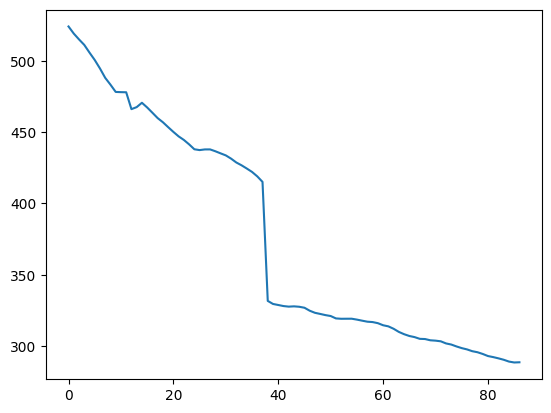

/var/folders/qh/nmm9q9bs54x0q1jtj38dc8kw0000gn/T/ipykernel_43985/1828918290.py:18: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

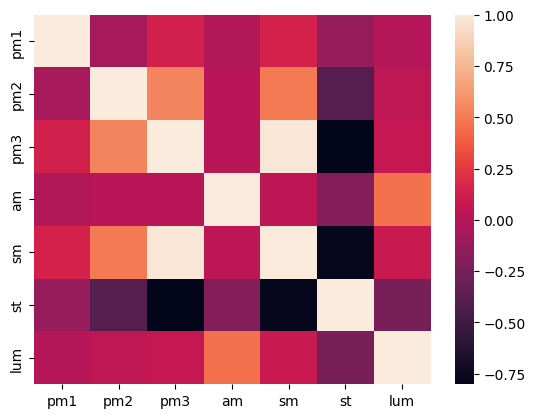

In [59]:
df = pd.read_csv("data1.csv")
df['date'] = pd.to_datetime(df['ttime'])
df = df.loc[(df['date'] > '2022-12-01') ]
df = df.reset_index(drop = True)
df.index.name = 'date'

df['timestamp'] = pd.to_datetime(df['ttime'])
df_grouped = df.groupby(df['timestamp'].dt.date).mean()


print(df_grouped.head())
feature_list = ['sm']
feature_list_len = len(feature_list)
values = df_grouped[feature_list].values
plt.plot(values[:, 0])
plt.show()

sns.heatmap(df.corr())


In [37]:
values = values.astype('float32')

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [39]:
reframed = series_to_supervised(scaled, 1, 1)

In [40]:
values = reframed.values

In [41]:
train = values[:int(0.8*(len(values))), :]
test = values[int(0.8*(len(values))):, :]

train_X, train_y = train[:, :-feature_list_len], train[:, -feature_list_len:]
test_X, test_y = test[:, :-feature_list_len], test[:, -feature_list_len:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(68, 1, 1) (68, 1) (18, 1, 1) (18, 1)


Epoch 1/30
1/1 - 1s - loss: 0.2974 - mae: 0.4499 - val_loss: 0.0014 - val_mae: 0.0307 - 1s/epoch - 1s/step
Epoch 2/30
1/1 - 0s - loss: 0.2949 - mae: 0.4474 - val_loss: 0.0013 - val_mae: 0.0295 - 15ms/epoch - 15ms/step
Epoch 3/30
1/1 - 0s - loss: 0.2926 - mae: 0.4451 - val_loss: 0.0012 - val_mae: 0.0284 - 16ms/epoch - 16ms/step
Epoch 4/30
1/1 - 0s - loss: 0.2904 - mae: 0.4429 - val_loss: 0.0011 - val_mae: 0.0272 - 15ms/epoch - 15ms/step
Epoch 5/30
1/1 - 0s - loss: 0.2882 - mae: 0.4407 - val_loss: 0.0010 - val_mae: 0.0261 - 14ms/epoch - 14ms/step
Epoch 6/30
1/1 - 0s - loss: 0.2860 - mae: 0.4385 - val_loss: 9.6685e-04 - val_mae: 0.0251 - 14ms/epoch - 14ms/step
Epoch 7/30
1/1 - 0s - loss: 0.2840 - mae: 0.4364 - val_loss: 8.9200e-04 - val_mae: 0.0241 - 15ms/epoch - 15ms/step
Epoch 8/30
1/1 - 0s - loss: 0.2819 - mae: 0.4342 - val_loss: 8.2283e-04 - val_mae: 0.0233 - 15ms/epoch - 15ms/step
Epoch 9/30
1/1 - 0s - loss: 0.2799 - mae: 0.4320 - val_loss: 7.5953e-04 - val_mae: 0.0225 - 14ms/epoch -

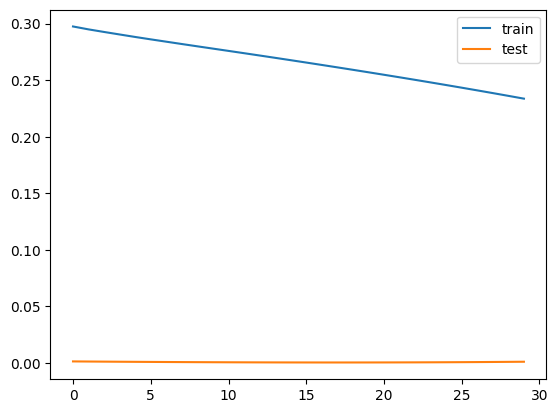

In [42]:
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(25, activation='relu', return_sequences=True))

model.add(Dense(feature_list_len))
model.compile(loss='mse', optimizer='adam', metrics='mae')
history = model.fit(train_X, train_y, epochs=30, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [43]:
yhat = model.predict(test_X)
yhat = yhat.reshape((-1, feature_list_len))
# # test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# # # invert scaling for forecast
# # inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(yhat)
inv_yhat = inv_yhat[:,0]

# # test_y = test_y.reshape((len(test_y), 1))
# # inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(test_y)
inv_y = inv_y[:,0]

1/1 [==============================] - 0s 153ms/step


In [44]:
rmse = mean_squared_error(inv_y, inv_yhat, squared=False)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 7.942


In [45]:
pred = []*len(test_X)
testing = train_X[-1]
testing = testing.reshape((1, 1, feature_list_len))
temp = model.predict(testing, verbose=0)
testing = temp[0].reshape((1, 1, feature_list_len))
for _ in range(len(test_X)):
    # print(testing)
    temp = model.predict(testing, verbose=0)
    pred.append(temp[0])
    testing = pred[-1].reshape((1, 1, feature_list_len))

In [46]:
pred = np.array(pred)
pred = pred.reshape((-1, feature_list_len))
pred = scaler.inverse_transform(pred)
pred = pred[:,0]
rmse = mean_squared_error(inv_y, pred, squared=False)
print('Test RMSE: %.3f' % rmse)

Test RMSE: 8.208


In [55]:
pred = []*20
testing = test_X[-1]
testing = testing.reshape((1, 1, feature_list_len))
temp = model.predict(testing, verbose=0)
testing = temp[0].reshape((1, 1, feature_list_len))
for _ in range(20):
    temp = model.predict(testing, verbose=0)
    pred.append(temp[0])
    testing = pred[-1].reshape((1, 1, feature_list_len))

In [56]:
pred = np.array(pred)
pred = pred.reshape((-1, feature_list_len))
pred = scaler.inverse_transform(pred)
pred = pred[:,0]
print(pred)

[302.40503 302.42206 302.42267 302.4227  302.4227  302.4227  302.4227
 302.4227  302.4227  302.4227  302.4227  302.4227  302.4227  302.4227
 302.4227  302.4227  302.4227  302.4227  302.4227  302.4227 ]


In [ ]:
#Final Prediction

In [51]:
train = values

train_X, train_y = train[:, :-feature_list_len], train[:, -feature_list_len:]

train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
print(train_X.shape, train_y.shape)

(86, 1, 1) (86, 1)


Epoch 1/30
1/1 - 2s - loss: 0.2361 - mae: 0.3630 - val_loss: 0.0014 - val_mae: 0.0309 - 2s/epoch - 2s/step
Epoch 2/30
1/1 - 0s - loss: 0.2346 - mae: 0.3612 - val_loss: 0.0013 - val_mae: 0.0297 - 14ms/epoch - 14ms/step
Epoch 3/30
1/1 - 0s - loss: 0.2332 - mae: 0.3594 - val_loss: 0.0012 - val_mae: 0.0286 - 15ms/epoch - 15ms/step
Epoch 4/30
1/1 - 0s - loss: 0.2317 - mae: 0.3577 - val_loss: 0.0012 - val_mae: 0.0275 - 18ms/epoch - 18ms/step
Epoch 5/30
1/1 - 0s - loss: 0.2302 - mae: 0.3559 - val_loss: 0.0011 - val_mae: 0.0264 - 20ms/epoch - 20ms/step
Epoch 6/30
1/1 - 0s - loss: 0.2287 - mae: 0.3541 - val_loss: 9.9762e-04 - val_mae: 0.0255 - 19ms/epoch - 19ms/step
Epoch 7/30
1/1 - 0s - loss: 0.2272 - mae: 0.3524 - val_loss: 9.2573e-04 - val_mae: 0.0246 - 18ms/epoch - 18ms/step
Epoch 8/30
1/1 - 0s - loss: 0.2258 - mae: 0.3507 - val_loss: 8.5888e-04 - val_mae: 0.0237 - 16ms/epoch - 16ms/step
Epoch 9/30
1/1 - 0s - loss: 0.2243 - mae: 0.3490 - val_loss: 7.9710e-04 - val_mae: 0.0230 - 15ms/epoch -

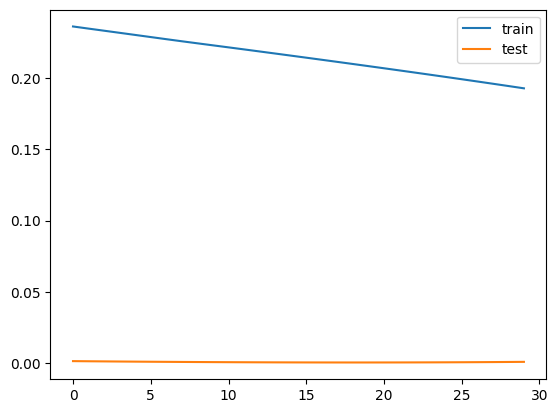

In [52]:
final_model = Sequential()
final_model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
final_model.add(LSTM(25, activation='relu', return_sequences=True))

final_model.add(Dense(feature_list_len))
final_model.compile(loss='mse', optimizer='adam', metrics='mae')
history = final_model.fit(train_X, train_y, epochs=30, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [53]:
pred = []*20
testing = test_X[-1]
testing = testing.reshape((1, 1, feature_list_len))
temp = final_model.predict(testing, verbose=0)
testing = temp[0].reshape((1, 1, feature_list_len))
for _ in range(20):
    # print(testing)
    temp = final_model.predict(testing, verbose=0)
    pred.append(temp[0])
    testing = pred[-1].reshape((1, 1, feature_list_len))

In [54]:
pred = np.array(pred)
pred = pred.reshape((-1, feature_list_len))
pred = scaler.inverse_transform(pred)
pred = pred[:,0]
print(pred)

[301.1816  301.18842 301.18854 301.18854 301.18854 301.18854 301.18854
 301.18854 301.18854 301.18854 301.18854 301.18854 301.18854 301.18854
 301.18854 301.18854 301.18854 301.18854 301.18854 301.18854]
